![zad1.png](images/note5/zad1.png)

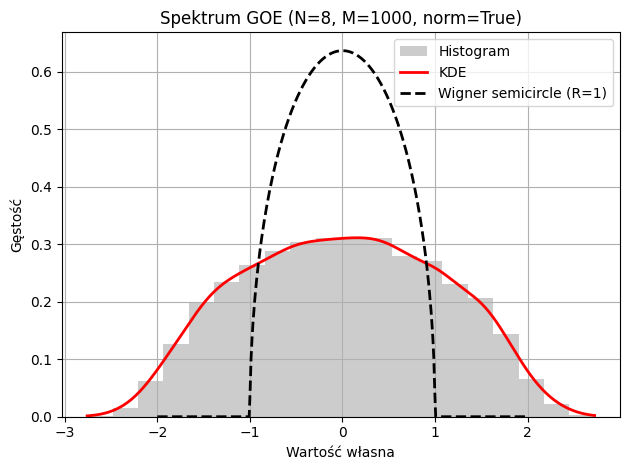

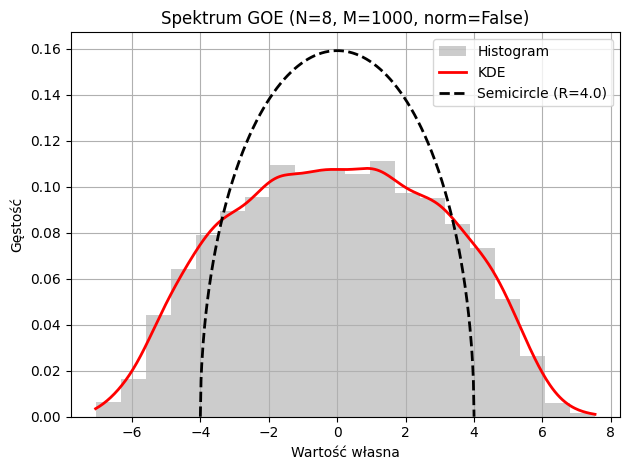

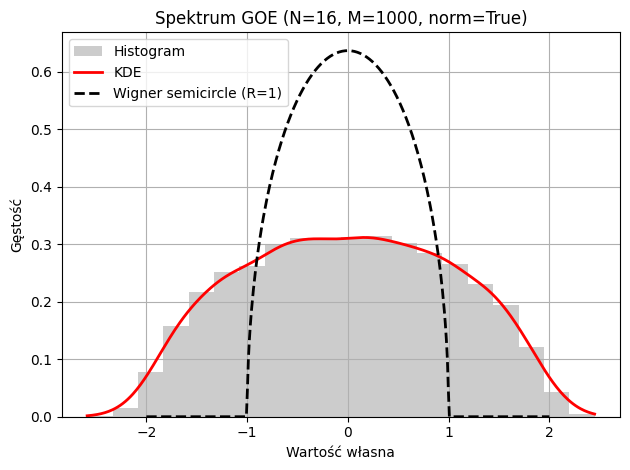

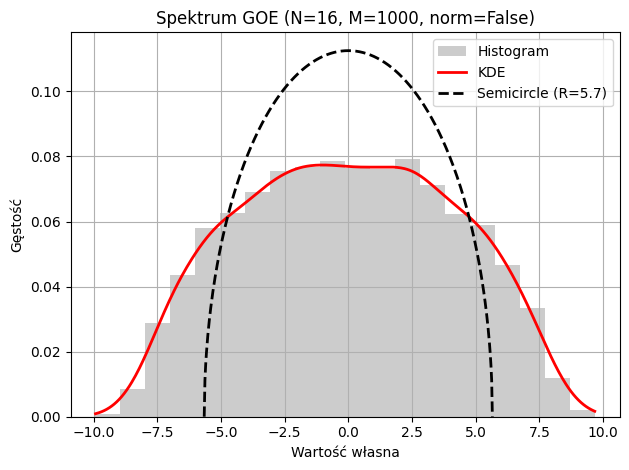

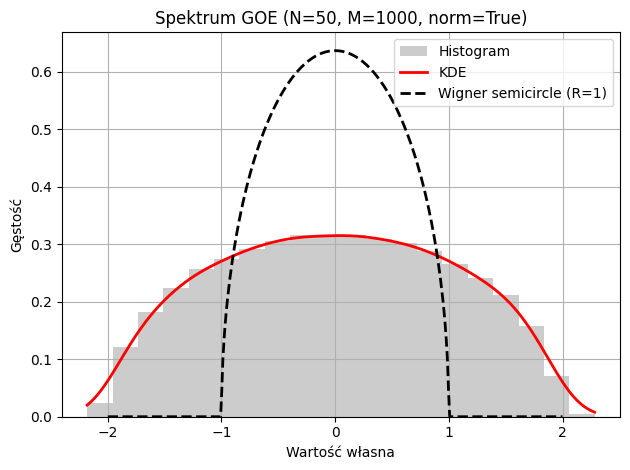

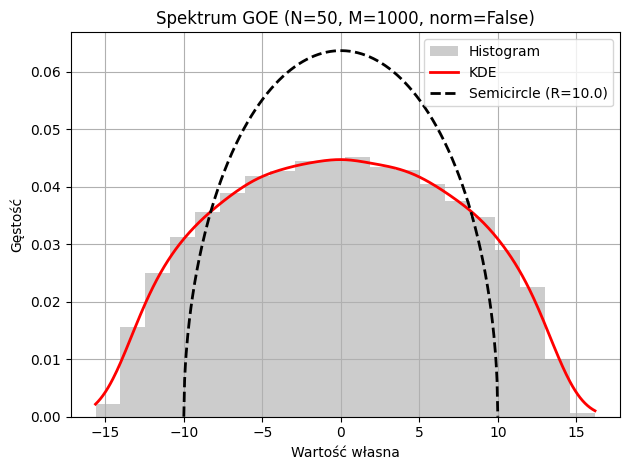

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def generate_goe_matrix(N, sigma=np.sqrt(2)):
    # generujemy macierz M z rozkładu normalnego N(0, sigma^2)
    M = np.random.normal(loc=0, scale=sigma, size=(N, N))
    # tworzymy macierz GOE przez symetryzację i normalizację przez 2√N
    X = (M + M.T) / (2 * np.sqrt(N))
    return X

def generate_goe_matrix_no_norm(N, sigma=np.sqrt(2)):
    # generujemy macierz M z rozkładu normalnego N(0, sigma^2)
    M = np.random.normal(loc=0, scale=sigma, size=(N, N))
    # tworzymy macierz GOE przez symetryzację, ale bez normalizacji przez sqrt(N)
    X = (M + M.T) / 2
    return X

def wigner_semicircle(x, R=1):
    # implementacja teoretycznego rozkładu półkola Wignera z promieniem R
    mask = abs(x) <= R
    result = np.zeros_like(x)
    result[mask] = (2 / (np.pi * R**2)) * np.sqrt(R**2 - x[mask]**2)
    return result

def plot_spectrum(N, M=1000, normalize=True):
    eigenvalues = []

    # generujemy M macierzy i obliczamy ich wartości własne
    for _ in range(M):
        if normalize:
            matrix = generate_goe_matrix(N)      # normalizacja przez 2√N
        else:
            matrix = generate_goe_matrix_no_norm(N)  # bez normalizacji
        eigenvalues.extend(np.linalg.eigvalsh(matrix))

    eigenvalues = np.array(eigenvalues)

    # wygładzamy rozkład za pomocą KDE (kernel density estimation)
    kde = gaussian_kde(eigenvalues, bw_method=0.18)
    x_min = eigenvalues.min()
    x_max = eigenvalues.max()
    x = np.linspace(x_min, x_max, 400)

    # histogram o małej liczbie binów, aby nie było sztucznych "schodków"
    plt.hist(eigenvalues, bins=20, density=True, alpha=0.4, label='Histogram', color='gray')
    # wykres gęstości KDE (wygładzony)
    plt.plot(x, kde(x), 'r-', lw=2, label='KDE')

    # teoretyczny rozkład półkola Wignera
    if normalize:
        x_w = np.linspace(-2, 2, 400)
        plt.plot(x_w, wigner_semicircle(x_w, R=1), 'k--', label='Wigner semicircle (R=1)', lw=2)
    else:
        # przy nieznormalizowanej macierzy promień półkola się zwiększa
        R = np.sqrt(2 * N)
        x_w = np.linspace(-R, R, 400)
        plt.plot(x_w, wigner_semicircle(x_w, R=R), 'k--', label=f'Semicircle (R={R:.1f})', lw=2)

    plt.title(f"Spektrum GOE (N={N}, M={M}, norm={normalize})")
    plt.xlabel("Wartość własna")
    plt.ylabel("Gęstość")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# sprawdzamy dla N = 8, 16, 50 z i bez normalizacji
for N in [8, 16, 50]:
    plot_spectrum(N, M=1000, normalize=True)   # Z normalizacją
    plot_spectrum(N, M=1000, normalize=False)  # Bez normalizacji


![zad2.png](images/note5/zad2.png)


--- Obliczenia dla N = 8 ---
 k   Numeryczny (Brute-force)       Analityczny (Wigner)
 1                  -0.002335                   0.000000
 2                   1.122571                   1.000000
 3                   0.007185                   0.000000
 4                   2.681762                   2.000000
 5                   0.067247                   0.000000
 6                   8.509204                   5.000000
 7                   0.485076                   0.000000
 8                  32.061088                  14.000000
 9                   3.336277                   0.000000
10                 137.013017                  42.000000

--- Obliczenia dla N = 16 ---
 k   Numeryczny (Brute-force)       Analityczny (Wigner)
 1                   0.000191                   0.000000
 2                   1.062351                   1.000000
 3                   0.000894                   0.000000
 4                   2.335109                   2.000000
 5                   0.0015

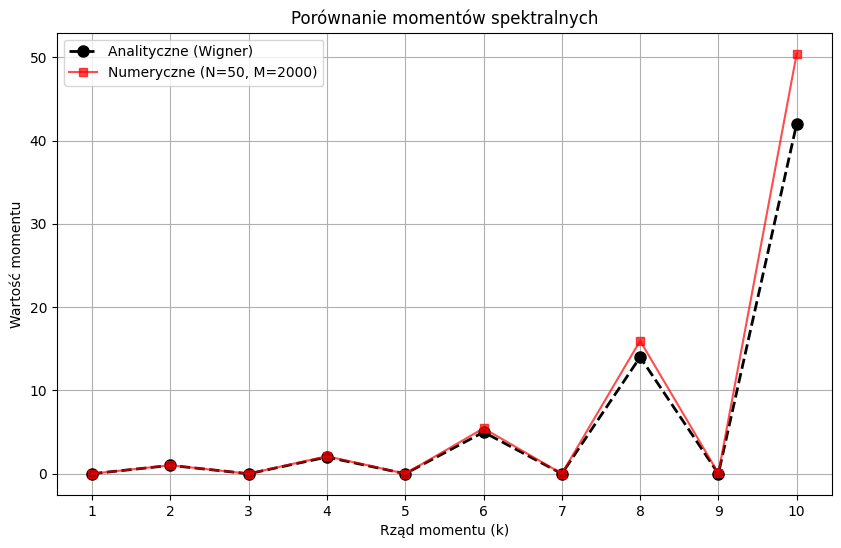

In [11]:
import math

def compute_moments(N, M=1000, max_order=10):
    # Obliczanie pierwszych max_order momentów spektralnych metodą brute-force
    moments = np.zeros(max_order)
    for _ in range(M):
        X = generate_goe_matrix(N)
        eigvals = np.linalg.eigvalsh(X)
        for k in range(1, max_order + 1):
            moments[k - 1] += np.mean(eigvals**k)
    moments /= M
    return moments

def wigner_analytic_moments(max_order=10, R=1):
    # Obliczanie analityczne momentów rozkładu półkola Wignera o promieniu R.
    moments = []
    for k in range(1, max_order + 1):
        if k % 2 == 1:
            moments.append(0)  # Nieparzyste momenty są równe zero
        else:
            n = k // 2
            catalan = math.factorial(2 * n) / (math.factorial(n) * math.factorial(n + 1))
            moment = catalan * (R/2)**k
            moments.append(moment)
    return moments

N_values = [8, 16, 50] # Wymiary macierzy
M_samples = 2000
max_order = 10 # Liczba momentów do obliczenia

analytic_moments = wigner_analytic_moments(max_order=max_order, R=2)

results = {}
for N in N_values:
    print(f"\n--- Obliczenia dla N = {N} ---")
    brute_force_moments = compute_moments(N=N, M=M_samples, max_order=max_order)
    results[N] = brute_force_moments
    
    # Drukowanie porównania
    print(f"{'k':>2}  {'Numeryczny (Brute-force)':>25}  {'Analityczny (Wigner)':>25}")
    print("=" * 60)
    for k in range(1, max_order + 1):
        bf = brute_force_moments[k - 1]
        an = analytic_moments[k - 1]
        print(f"{k:>2}  {bf:25.6f}  {an:25.6f}")

non_zero_moments = [int(round(m)) for m in analytic_moments if m != 0]

# --- Wizualizacja wyników dla N=50 ---
plt.figure(figsize=(10, 6))
k_values = np.arange(1, max_order + 1)
plt.plot(k_values, analytic_moments, 'ko--', label='Analityczne (Wigner)', linewidth=2, markersize=8)
plt.plot(k_values, results[50], 'r-s', label=f'Numeryczne (N={50}, M={M_samples})', alpha=0.7)

plt.title('Porównanie momentów spektralnych')
plt.xlabel('Rząd momentu (k)')
plt.ylabel('Wartość momentu')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print(f"Pierwsze 5 niezerowych momentów analitycznych (k = 2, 4, 6, 8, 10) to: {non_zero_moments[:5]}")
print("Ta sekwencja to liczby Catalana: 1, 2, 5, 14, 42, ...")

Pierwsze 5 niezerowych momentów analitycznych (k = 2, 4, 6, 8, 10) to: [1, 2, 5, 14, 42]
Sekwencja ta to liczby Catalana: 1, 2, 5, 14, 42, ...


Parzyste momenty spektralne rozkładu półkola Wignera są liczbami Catalana.
Im wiekszy rozmiar macierzy tym bardziej zblizone są wyniki analityczne i numeryczne (brute-force).

![zad3.png](images/note5/zad3.png)

![zad4.png](images/note5/zad4.png)

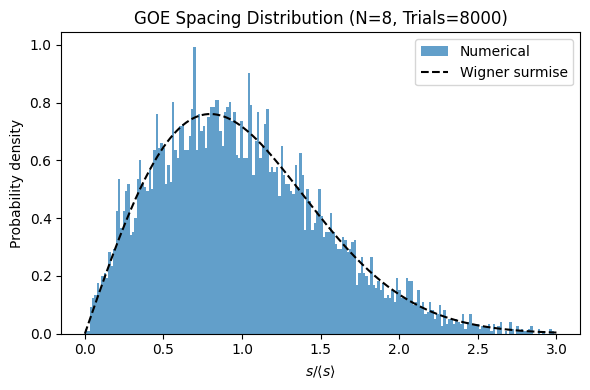

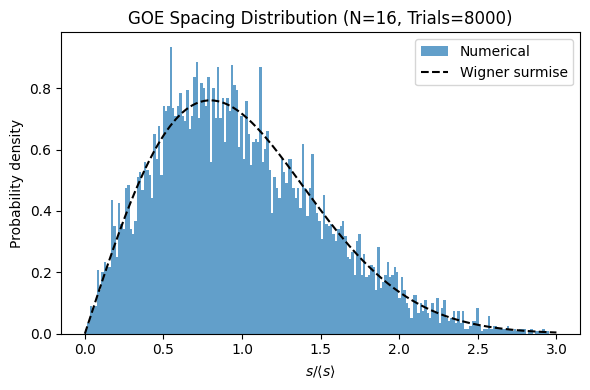

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def sample_goe(N):
    A = np.random.normal(size=(N, N))
    H = (A + A.T)/2
    # adjust diagonal variance to 2
    H[np.diag_indices(N)] *= np.sqrt(2)
    return H

def get_normalized_spacings(N, n_trials):
    spacings = []
    for _ in range(n_trials):
        H = sample_goe(N)
        ev = np.linalg.eigvalsh(H) # already sorted
        idx = N//2
        spacings.append(ev[idx+1] - ev[idx])
    spacings = np.array(spacings)
    return spacings / np.mean(spacings)

for N in [8, 16]:
    n_trials = 8000

    # get data
    s = get_normalized_spacings(N, n_trials)

    # plot histogram
    bins = np.arange(0, 3.0, 0.015)
    plt.figure(figsize=(6,4))
    plt.hist(s, bins=bins, density=True, alpha=0.7, label='Numerical')

    # Wigner surmise
    x = np.linspace(0, 3, 300)
    P = (np.pi / 2) * x * np.exp(-np.pi / 4 * x**2)
    plt.plot(x, P, 'k--', label="Wigner surmise")
    plt.xlabel(r'$s/\langle s\rangle$')
    plt.ylabel('Probability density')
    plt.title(f'GOE Spacing Distribution (N={N}, Trials={n_trials})')
    plt.legend()
    plt.tight_layout()
    plt.show()


![zad5.png](images/note5/zad5.png)

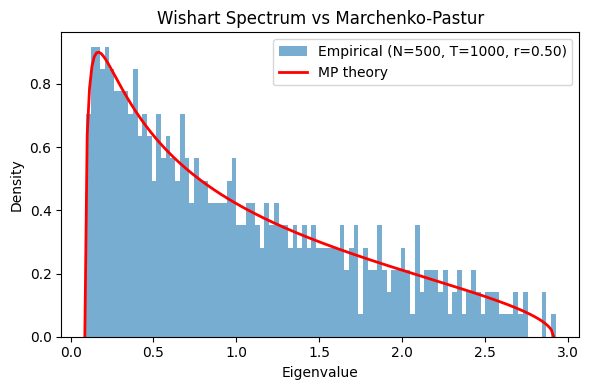

/tmp/ipykernel_2615/435615104.py:19: RuntimeWarning: invalid value encountered in divide
  mp_pdf = np.sqrt((lambda_plus - lam)*(lam - lambda_minus)) / (2 * np.pi * r * lam)


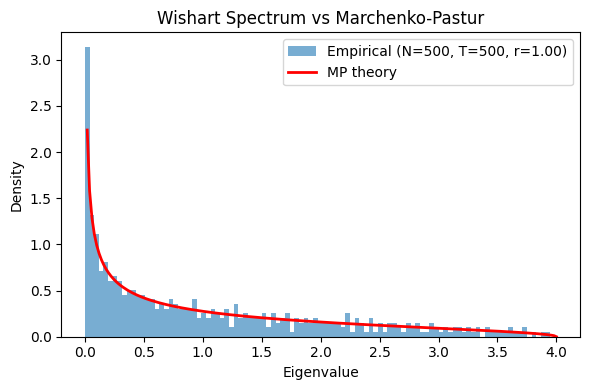

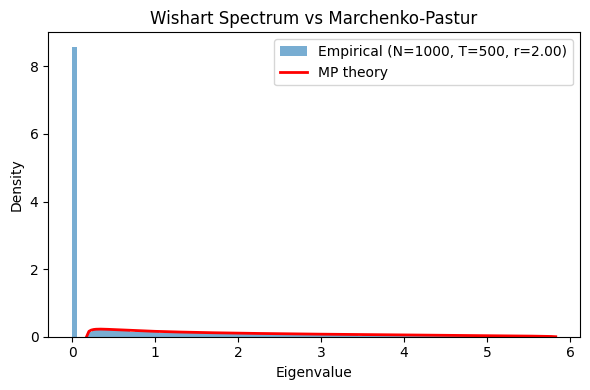

For N=500, T=1000 (r=0.50): lambda- = 0.086, lambda+ = 2.914
For N=500, T=500 (r=1.00): lambda- = 0.000, lambda+ = 4.000
For N=1000, T=500 (r=2.00): lambda- = 0.172, lambda+ = 5.828


In [77]:
import numpy as np
import matplotlib.pyplot as plt

def plot_wishart_spectrum(N, T, bins=100):
    r = N / T
    # simulate data
    X = np.random.randn(T, N)
    C = (X.T @ X) / T
    eigs = np.linalg.eigvalsh(C)

    # histogram
    plt.figure(figsize=(6,4))
    plt.hist(eigs, bins=bins, density=True, alpha=0.6, label='Empirical (N={}, T={:.0f}, r={:.2f})'.format(N, T, r))

    # theoretical MP
    lambda_minus = (1 - np.sqrt(r))**2
    lambda_plus = (1 + np.sqrt(r))**2
    lam = np.linspace(lambda_minus, lambda_plus, 200)
    mp_pdf = np.sqrt((lambda_plus - lam)*(lam - lambda_minus)) / (2 * np.pi * r * lam)
    
    plt.plot(lam, mp_pdf, 'r-', lw=2, label='MP theory')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.title('Wishart Spectrum vs Marchenko-Pastur')
    plt.legend()
    plt.tight_layout()

# Example cases
cases = [
    (500, 1000),  # r = 0.5 < 1
    (500, 500),   # r = 1
    (1000, 500)   # r = 2 > 1
]

for N, T in cases:
    plot_wishart_spectrum(N, T)
    plt.show()

# Compare edge locations explicitly
for N, T in cases:
    r = N / T
    lam_minus = (1 - np.sqrt(r))**2
    lam_plus = (1 + np.sqrt(r))**2
    print(f"For N={N}, T={T} (r={r:.2f}): lambda- = {lam_minus:.3f}, lambda+ = {lam_plus:.3f}")



![zad61.png](images/note5/zad61.png)  
![zad62.png](images/note5/zad62.png)

![zad7.png](images/note5/zad7.png)

Shape of return matrix R: (1308, 406)


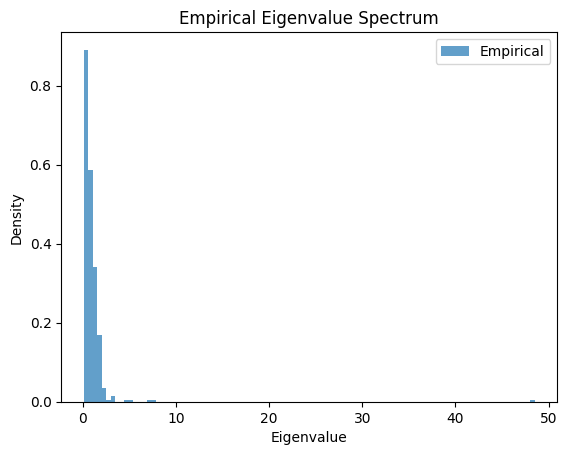

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eig

# 1) LOAD DATA
df = pd.read_csv('data/SP500_406x1308.dat',
                 sep=r'\s+', names=['id','t','ratio'])

# Calculate simple returns
df['return'] = df['ratio'] - 1

# 2) MEANS & VARIANCES
# -------------------------------------------------------------------
# For each company i, over all t:
means     = df.groupby('id')['return'].mean() 
variances = df.groupby('id')['return'].var()

# 3) BUILD STANDARDIZED RETURN MATRIX (T × N)
# -------------------------------------------------------------------
# Pivot to a T×N array R (rows=t, cols=id)
R = df.pivot(index='t', columns='id', values='return').values  # shape (T, N)

# Standardize each column i
mu = means.values 
sigma = np.sqrt(variances.values)
R_std = (R - mu[np.newaxis,:]) / sigma[np.newaxis,:]

# 4) COVARIANCE MATRIX & SPECTRUM
# -------------------------------------------------------------------
T, N = R_std.shape
C = (R_std.T @ R_std) / T      # N×N sample covariance of standardized data

# Eigenvalues
eigvals = np.linalg.eigvalsh(C)

# Plot empirical eigenvalue density
plt.figure()
plt.hist(eigvals, bins=100, density=True, alpha=0.7, label='Empirical')
plt.title('Empirical Eigenvalue Spectrum')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.show()

Marchenko-Pastur bounds for r=0.31:
lambda- = 0.196, lambda+ = 2.425


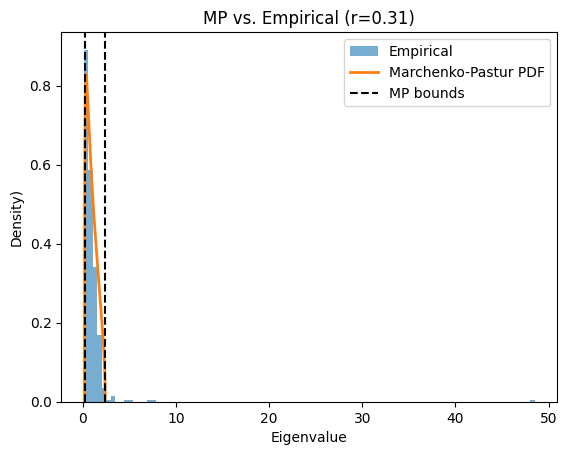

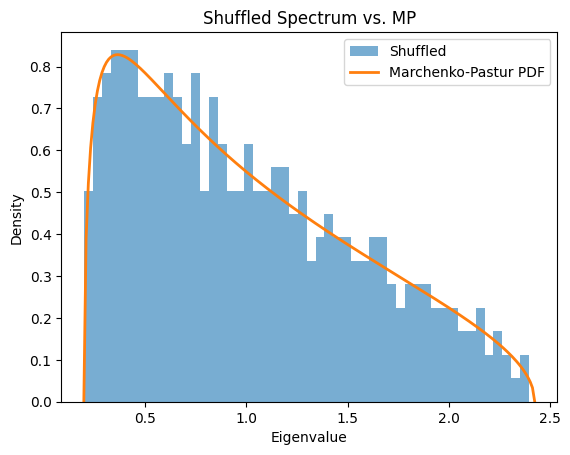

In [76]:
# 5) COMPARE TO Marchenko–Pastur bounds
# -------------------------------------------------------------------
r = N / T
lambda_minus = (1 - np.sqrt(r))**2
lambda_plus  = (1 + np.sqrt(r))**2

print(f"Marchenko-Pastur bounds for r={r:.2f}:")
print(f"lambda- = {lambda_minus:.3f}, lambda+ = {lambda_plus:.3f}")

# Overlay MP distribution
lam = np.linspace(lambda_minus, lambda_plus, 200)
mp_pdf = np.sqrt((lambda_plus - lam)*(lam - lambda_minus)) / (2 * np.pi * r * lam)

plt.figure()
plt.hist(eigvals, bins=100, density=True, alpha=0.6, label='Empirical')
plt.plot(lam, mp_pdf, lw=2, label='Marchenko-Pastur PDF')
plt.axvline(lambda_minus, color='k', linestyle='--', label='MP bounds')
plt.axvline(lambda_plus,  color='k', linestyle='--')
plt.title('Empirical Spectrum vs. Marchenko-Pastur')
plt.xlabel('Eigenvalue')
plt.ylabel('Density)')
plt.legend()
plt.title(f'MP vs. Empirical (r={r:.2f})')
plt.show()

# 6) DESTROY CORRELATIONS & RE-CALCULATE
# -------------------------------------------------------------------
# Shuffle each column independently
R_shuffled = np.copy(R_std)
for j in range(N):
    np.random.shuffle(R_shuffled[:,j])

# New covariance & eigenvalues
C_sh = (R_shuffled.T @ R_shuffled) / T
eigvals_sh = np.linalg.eigvalsh(C_sh)

# Plot & compare to MP again
plt.figure()
plt.hist(eigvals_sh, bins=50, density=True, alpha=0.6, label='Shuffled')
plt.plot(lam, mp_pdf, lw=2, label='Marchenko-Pastur PDF')
plt.title('Shuffled Spectrum vs. Marchenko-Pastur')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.title('Shuffled Spectrum vs. MP')
plt.show()